In [1]:
from FK import *
import pyvoro
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
%matplotlib notebook

Voronoi cell

In [3]:
def area_vertices(vertices):
    f_cm = np.mean(vertices,axis=0)
    vertices = vertices - f_cm
    i_1 = np.arange(len(vertices))
    i_2 = (i_1+1)%len(i_1)
    A = [np.cross(vertices[i_1[j]],vertices[i_2[j]]) for j in range(len(i_1))]
    area = np.linalg.norm(np.sum(A,axis=0)/2)
    return area

------------------
c/a ratio
0.5290

Counts    Volume    Coordinates    IQ
2         0.8965    12             0.7416
8         0.9379    12             0.7460
8         1.0144    14             0.7687
8         1.0349    14             0.7683
4         1.0773    15             0.7850

Unit cell volume 
30.0000



<IPython.core.display.Javascript object>


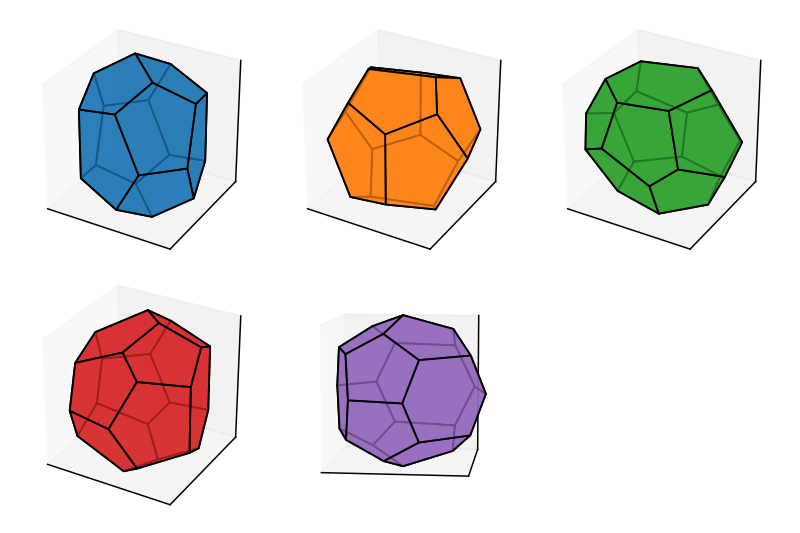

In [6]:
n_x = 1
n_y = 1
n_layers = 1

# Choose c/a ratio here
r_ca = [228/431]
# r_ca = [1/1.9]
# r_ca = [0.518]

# Iterate over c/a ratios
for i_r, r in enumerate(r_ca):
    e_SQ = np.array([[np.cos(x),np.sin(x)] for x in [0,np.pi/2]])
    e_TR = np.array([[np.cos(x),np.sin(x)] for x in [0,np.pi/3]])
    
    l_c = 1*np.sqrt((1+np.sqrt(3)/2)**2+0.5**2)*r
#     print(l_c)
    
    # Generate a FK sigma primitive unit cell
    c_layer_sigma = c_sigma(n_x,n_y,Ratio_ca=1/r)
    c_rod = stack_coords([shift_coords(c_layer_sigma, np.array([0,0,l_c])*s) for s in range(n_layers)])

    l = np.sqrt((1+np.sqrt(3)/2)**2+0.5**2)
    bounds = np.array([[0,n_x*l],[0,n_y*l],[0,n_layers*l_c]])
    points = np.vstack(c_rod)
    
    # Call pyvoro.compute_voronoi function to evaluate the Voronoi tessellations
    voro = pyvoro.compute_voronoi(points,bounds,0.7,periodic=[True]*3)
    
    list_origin = [v['original'] for v in voro]
    list_volume = [v['volume'] for v in voro]
    list_volume_round = [np.round(v['volume'],decimals=9) for v in voro]
    list_vertices = [v['vertices'] for v in voro]
    list_adjacency = [v['adjacency'] for v in voro]
    list_faces = [v['faces'] for v in voro]
    list_coords = [len(v['faces']) for v in voro]
    
    # Pick up the unique elements from the list of Voronoi cell volume
    unique_volume, inices, counts = np.unique(list_volume_round,return_counts=True,return_index=True)
    unique_volume_reduced = unique_volume*np.sum(counts)/np.sum(counts*unique_volume)
    unique_adjacency = np.array(list_coords)[inices]
    
    # Isoperimetric quotient (IQ)
    unique_IQ = []
    for i_cell in range(len(unique_volume)):
        vertices = np.array(list_vertices[inices.tolist()[i_cell]])
        v_cm = np.mean(vertices,axis=0)
        vertices = vertices-v_cm
        faces = list_faces[inices.tolist()[i_cell]]
    
        area_sum = 0
        for i_faces, face in enumerate(faces):
            vertices_face_list = vertices[face['vertices']].tolist()
            area = area_vertices(vertices_face_list)
            area_sum += area
            
        unique_IQ.append(36*np.pi*unique_volume[i_cell]**2/area_sum**3)
    
    # Print the results
    print('------------------')
    print('c/a ratio\n{:0.4f}'.format(r))
    print('\nCounts    Volume    Coordinates    IQ')
    for i in range(len(counts)):
        print('{:d}         {:0.4f}    {:d}             {:0.4f}'.format(counts[i], 
                                                    unique_volume_reduced[i], 
                                                    unique_adjacency[i],
                                                    unique_IQ[i]))
        
    print('\nUnit cell volume \n{:0.4f}\n'.format(sum(counts*unique_volume_reduced)))
    
fig = plt.figure(figsize=(6,4))
colors = ['C0','C1','C2','C3','C4']
box_size = 0.3

for i_cell in range(len(unique_volume)):
    ax = fig.add_subplot(2, 3, i_cell+1, projection='3d')
    ax.set_box_aspect([1,1,1])

    vertices = np.array(list_vertices[inices.tolist()[i_cell]])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices-v_cm
    faces = list_faces[inices.tolist()[i_cell]]

    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        pgs = [list(tuple(x for x in v) for v in vertices_face_list)]
        collection_v = Poly3DCollection(pgs, 
                                        facecolors=colors[i_cell], linewidths=1, edgecolors='k', alpha=.75)

        ax.add_collection3d(collection_v)

    
    ax.set_xlim(-box_size,box_size)
    ax.set_ylim(-box_size,box_size)
    ax.set_zlim(-box_size,box_size)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.tight_layout()
plt.show()

### Select Voronoi polyhedra and evaluate strain energy

In [266]:
def sphere_sample(n):
    samples = []
    for i in range(n):
        v = [0, 0, 0]  # initialize so we go into the while loop

        while np.linalg.norm(v) < .0001:
            x = np.random.normal()  # random standard normal
            y = np.random.normal()
            z = np.random.normal()
            v = np.array([x, y, z])

        v = v/np.linalg.norm(v)  # normalize to unit norm
        
        samples.append(v)
        
    return np.array(samples)

def isinside(v, vt_polygon):
    len_vt = len(vt_polygon)
    list_inside = [np.dot(v,np.cross(vt_polygon[i],vt_polygon[(i+1)%len_vt]))<=0
               for i in range(len_vt)]
    return np.all(list_inside) 

In [280]:
list_voronoi = [4]

n_sample = 100
vect_sample = sphere_sample(n_sample)

for i_cell in list_voronoi:
    E = 0
    r_ave = 0
    
    vertices = np.array(list_vertices[inices.tolist()[i_cell]])
    volume = np.array(list_volume[inices.tolist()[i_cell]])
    radius_sphere = (volume/(4/3*np.pi))**(1/3)
    l_0 = radius_sphere
    r_OI = l_0/2
    r_IS = l_0-r_OI
    
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices-v_cm
    faces = list_faces[inices.tolist()[i_cell]]
    
    for i_faces, face in enumerate(faces):
        vt_sf_list = vertices[face['vertices']].tolist()
        vt_if_list = (vertices[face['vertices']]/2).tolist()
        
        v0 = np.array(vt_sf_list[0])
        v1 = np.array(vt_sf_list[1])
        v2 = np.array(vt_sf_list[2])
        v0_i = np.array(vt_if_list[0])
        
        n_sf = np.cross((v1-v0),
                        (v1-v2))
        n_sf = n_sf/np.linalg.norm(n_sf)
        
        index_inside = [isinside(v,vt_sf_list) for v in vect_sample]
        vect_inside = vect_sample[index_inside]
        
        for vect in vect_inside:
            d_OS = np.abs(np.dot(v0,n_sf)/np.dot(vect,n_sf))
            d_OI = np.abs(np.dot(v0_i,n_sf)/np.dot(vect,n_sf))
            d_IS = d_OS-d_OI
            
            stretch_OI = d_OI-r_OI
            stretch_IS = d_IS-r_IS
            
            r_ave += d_OS/n_sample

<IPython.core.display.Javascript object>


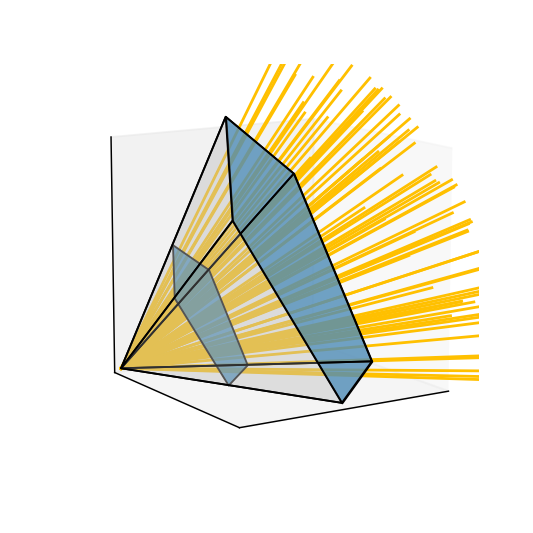

[]

In [222]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(elev=24, azim=-132)
ax.set_box_aspect([1,1,1])

pg_side = []
for i in range(len(vertices_face_list)):
    j = (i+1)%len(vertices_face_list)
    triangle = ([0,0,0],vertices_face_list[i],vertices_face_list[j])
    pg_side.append(triangle)

pg_base = [list(tuple(x for x in v) for v in vertices_face_list)]
pg_base_shift = [list(tuple(x for x in v) for v in np.array(vertices_face_list)/2)]

collection_base = Poly3DCollection(pg_base, 
                                facecolors=colors[i_cell], linewidths=1, edgecolors='k', alpha=.75)
collection_base_shift = Poly3DCollection(pg_base_shift, 
                                facecolors=colors[i_cell], linewidths=1, edgecolors='k', alpha=.75)
collection_side = Poly3DCollection(pg_side, 
                                facecolors='#C0C0C0', linewidths=1, edgecolors='k', alpha=.25)

ax.add_collection3d(collection_base)
ax.add_collection3d(collection_base_shift)
ax.add_collection3d(collection_side)

n_sample = 1000
vect_sample = sphere_sample(n_sample)
for i in range(n_sample):
    if isinside(vect_sample[i],vertices_face_list):
        ax.plot([0,vect_sample[i,0]/2],[0,vect_sample[i,1]/2],[0,vect_sample[i,2]/2],'-',color='#FFC000')


# ax.plot([0,intersect[0]],[0,intersect[1]],[0,intersect[2]],'-',color='r',lw=2)        
        
ax.set_xlim(0,box_size)
ax.set_ylim(-box_size,0)
ax.set_zlim(0,box_size)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

In [160]:
[0,intersect[2]]

[0, 0.6170030597523327]

In [113]:
intersect

array([ 0.16376268, -0.16376268,  0.16376268])